In [1]:
import numpy as np
import matplotlib.pyplot as plt

class MultiLayerPerceptron:
  def __init__(self, architecture):
    self.architecture = architecture
    self.weights = []
    self.biases = []

    #Intializing random weights and biases zero
    np.random.seed(90) # np.random() is a module, not a callable function. Use np.random.seed() to set the seed.
    for i in range(len(architecture)-1):
      self.weights.append(np.random.uniform(low=-1, high=1, size=(architecture[i], architecture[i+1])))
      self.biases.append(np.zeros((1, architecture[i+1])))

architecture = [2,64,64,64,1]
model = MultiLayerPerceptron(architecture)

print('weight dimensions:')
for w in model.weights:
    print(w.shape)

print('\nbias dimensions:')
for b in model.biases:
    print(b.shape)

weight dimensions:
(2, 64)
(64, 64)
(64, 64)
(64, 1)

bias dimensions:
(1, 64)
(1, 64)
(1, 64)
(1, 1)


Multilayer Perceptron Pass Input to Each Layer

In [2]:
class MultilayerPerceptron:
    def __init__(self, architecture):
        self.architecture=architecture
        self.weights=[]
        self.biases=[]

        # tracking the input and outputs for visualization
        self.perceptron_inputs=None
        self.perceptron_ouputs=None

        # initialize weights and biases
        np.random.seed(99)
        for i in range(len(architecture) - 1):
            # we use numpy generate an array of random numbers drawn from a uniform distribution within a specified range
            self.weights.append(np.random.uniform(
                low=-1, high=1, size=(architecture[i], architecture[i+1])
            ))
            self.biases.append(np.zeros((1, architecture[i+1])))

    @staticmethod
    def relu(x):
        # implementing the relu activation function
        return np.maximum(0,x)

    @staticmethod
    def relu_as_weights(x):
        return (x>0).astype(float)

    def forward(self, X):
        self.perceptron_inputs=[X]
        self.perceptron_outputs=[]

        #iterating through all layers
        for W,b in zip(self.weights, self.biases):
          # applying the weight and biases of the layer
            # The dot product is a fundamental operation in linear algebra,
            #   for computing the weighed sum fo inputs at each layer.
            Z=np.dot(self.perceptron_inputs[-1], W)+b
            self.perceptron_outputs.append(Z)

            #doing ReLU for all but the last layer
            if W is self.weights[-1]:
                A=Z
            else:
                A=self.relu(Z)
            self.perceptron_inputs.append(A)

        return self.perceptron_inputs, self.perceptron_outputs

    def predict(self, x):
        perceptron_inputs, _=self.forward(x)
        return perceptron_inputs[-1].flatten() # convert the output to one-dimensional array


architecture =[2,64,64,64,1]
model=MultilayerPerceptron(architecture)

In [3]:
prediction=model.predict(np.array([0.1,0.2]))

for i, (inpt, outpt) in enumerate(zip(model.perceptron_inputs, model.perceptron_outputs[:-1])):
    print(f'layer {i}')
    print(f'input: {inpt.shape}')
    print(f'output: {outpt.shape}')
    print('')

print('Final Ouput:')
print(model.perceptron_outputs[-1].shape)


layer 0
input: (2,)
output: (1, 64)

layer 1
input: (1, 64)
output: (1, 64)

layer 2
input: (1, 64)
output: (1, 64)

Final Ouput:
(1, 1)


Creating a Dataset Consisting of Random Points

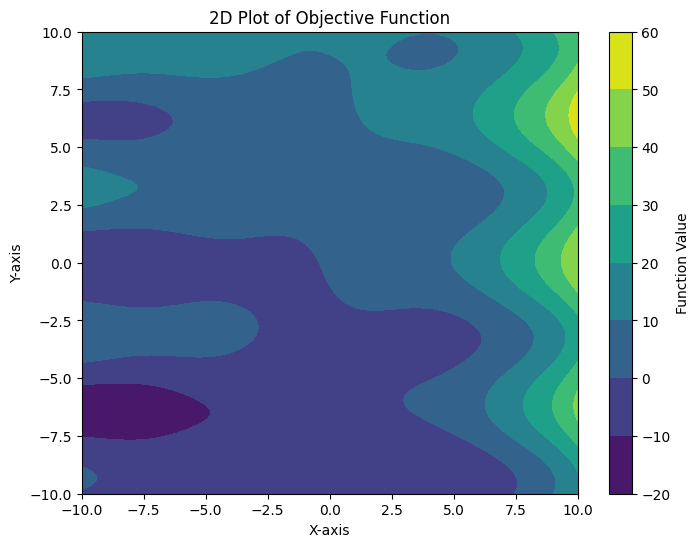

In [4]:
# Define a random function with two inputs
def random_function(x, y):
    return (np.sin(x) + x * np.cos(y) + y + 3**(x/3))

# Generate a grid of x and y values
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

# Compute the output of the random function
Z = random_function(X, Y)

# Create a 2D plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, cmap='viridis')
plt.colorbar(contour, label='Function Value')
plt.title('2D Plot of Objective Function')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

          X         Y         Z
0  3.445571  4.917359  8.851057
1 -0.238432 -4.594719 -3.886519
2  6.509903  3.368406  8.097718
3 -9.371072  6.061134 -3.101206
4  6.160999  3.071375  6.350257


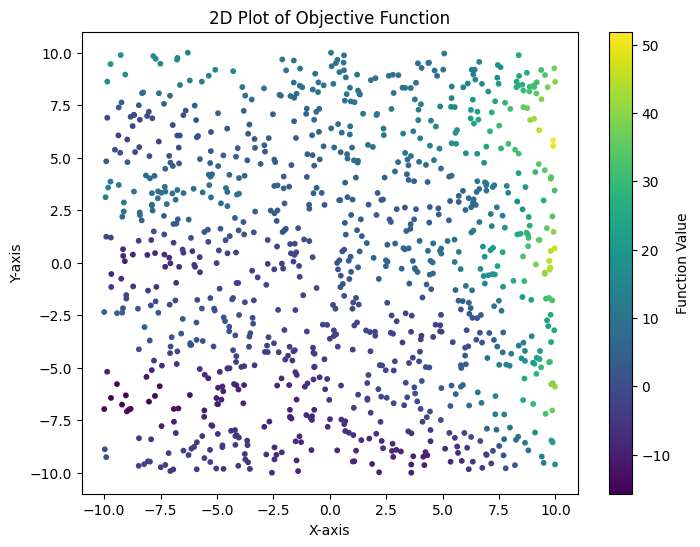

In [5]:
import pandas as pd

# define a random funciton with two inputs
def random_function(x,y):
    return (np.sin(x)+x*np.cos(y)+y+3**(x/3))

# define the nunmber of random sampels to generate
n_samples=1000

np.random.seed(99)
# generate a grid of x and y values
x_min, x_max=-10, 10
y_min, y_max=-10, 10

# generate random values fro X and Y
X_random=np.random.uniform(x_min, x_max, n_samples)
Y_random=np.random.uniform(y_min, y_max, n_samples)

# evalute the random function at the genreted X and Y values
Z_random=random_function(X_random, Y_random)


# Create a dataset
dataset=pd.DataFrame({
    'X':X_random,
    'Y':Y_random,
    'Z':Z_random
})

print(dataset.head())


# Create a 2D plot
plt.figure(figsize=(8, 6))
scatter=plt.scatter(dataset['X'],dataset['Y'], c=dataset['Z'], cmap='viridis', s=10)
plt.colorbar(scatter, label='Function Value')
plt.title('2D Plot of Objective Function')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

Multilayer Perceptron With Backpropagation and Training Functions

In [6]:
class MultilayerPerceptron:
    def __init__(self, architecture):
        self.architecture=architecture
        self.weights=[]
        self.biases=[]

        # initialize weights and biases
        np.random.seed(99)
        for i in range(len(architecture) - 1):
            # we use numpy generate an array of random numbers drawn from a uniform distribution within a specified range
            self.weights.append(np.random.uniform(
                low=-1, high=1, size=(architecture[i], architecture[i+1])
            ))
            self.biases.append(np.zeros((1, architecture[i+1])))

    @staticmethod
    def relu(x):
        # implementing the relu activation function
        return np.maximum(0,x)

    @staticmethod
    def relu_as_weights(x):
        # relu activation function
        return (x>0).astype(float)

    def forward(self, X):
        perceptron_inputs=[X]
        perceptron_outputs=[]

        #iterating through all layers
        for W,b in zip(self.weights, self.biases):

            # applying the weight and biases of the layer
            # The dot product is a fundamental operation in linear algebra,
            #   for computing the weighed sum fo inputs at each layer.
            Z=np.dot(perceptron_inputs[-1], W)+b
            perceptron_outputs.append(Z)

            #doing ReLU for all but the last layer
            if W is self.weights[-1]:
                A=Z
            else:
                A=self.relu(Z)
            perceptron_inputs.append(A)

        return perceptron_inputs, perceptron_outputs

    def backward(self, perceptron_inputs, perceptron_outputs, target):
        weight_changes=[]
        bias_changes=[]

        # a scaling factor for the batch size.
        # we want changes to be an average across all bacthes so we divide by m once we've aggregated all changes
        m=len(target)

        dA=perceptron_inputs[-1]-target.reshape(-1, 1) # output layer gradient or output error

        for i in reversed(range(len(self.weights))):
            # only for the last layer
            dZ=dA if i ==len(self.weights) -1 else dA *self.relu_as_weights(perceptron_outputs[i])

            # calculating change to weights
            # The change in the weight should be equal to the value going into the perceptron, times how much the ooutput should have changed.
            dW=np.dot(perceptron_inputs[i].T, dZ) / m

            # calculating change to bias
            db=np.sum(dZ,axis=0, keepdims=True) / m

            # keeping track of required changes
            weight_changes.append(dW)
            bias_changes.append(db)

            if i>0:
                dA=np.dot(dZ, self.weights[i].T)

        return list(reversed(weight_changes)), list(reversed(bias_changes))


    def update_weights(self, weight_changes, bias_changes, lr):
        for i in range(len(self.weights)):
            self.weights[i]-=lr*weight_changes[i]
            self.biases[i]-=lr*bias_changes[i]

    def train(self, X, y, epochs, lr=0.01):
        for epoch in range(epochs):
            perceptron_inputs, perceptron_outputs = self.forward(X)
            weight_changes, bias_changes = self.backward(perceptron_inputs, perceptron_outputs, y)
            self.update_weights(weight_changes, bias_changes, lr)

            if epoch % 20 == 0 or epoch == epochs - 1:
                loss = np.mean((perceptron_inputs[-1].flatten() - y) ** 2)  # MSE
                print(f"EPOCH {epoch}: Loss = {loss:.4f}")

    def predict(self, X):
        perceptron_inputs, _=self.forward(X)
        return perceptron_inputs[-1].flatten() # convert the output to one-dimensional array


architecture =[2,64,64,64,1]
model=MultilayerPerceptron(architecture)

# defining a sample input and target output
inpt=np.array([[0.1, 0.2]])
desired_output=np.array([0.5])

print(f'input: {inpt.shape}')
print(f'output: {desired_output.shape}')

#doing forward and backward pass to calculate changes
perceptron_inputs, perceptron_outputs=model.forward(inpt)
weight_changes, bias_changes=model.backward(perceptron_inputs, perceptron_outputs, desired_output)

# smaller numbers for printing
np.set_printoptions(precision=2)

for i, (layer_weights, layer_biases, layer_weight_changes, layer_bias_changes) in enumerate(zip(model.weights, model.biases, weight_changes, bias_changes)):
    print(f'layer {i}')
    print(f'weight matrix: {layer_weights.shape}')
    print(f'weight matrix changes: {layer_weight_changes.shape}')
    print(f'bias matrix: {layer_biases.shape}')
    print(f'bias matrix changes: {layer_bias_changes.shape}')
    print('')

print('The weight and weight change matrix of the second layer')
print('weight matrix:')
print(model.weights[1])
print('change matrix:')
print(weight_changes[1])

input: (1, 2)
output: (1,)
layer 0
weight matrix: (2, 64)
weight matrix changes: (2, 64)
bias matrix: (1, 64)
bias matrix changes: (1, 64)

layer 1
weight matrix: (64, 64)
weight matrix changes: (64, 64)
bias matrix: (1, 64)
bias matrix changes: (1, 64)

layer 2
weight matrix: (64, 64)
weight matrix changes: (64, 64)
bias matrix: (1, 64)
bias matrix changes: (1, 64)

layer 3
weight matrix: (64, 1)
weight matrix changes: (64, 1)
bias matrix: (1, 1)
bias matrix changes: (1, 1)

The weight and weight change matrix of the second layer
weight matrix:
[[ 0.41 -0.2   0.24 ... -0.77 -0.7   0.22]
 [ 0.69 -0.13 -0.07 ...  0.95 -0.77 -0.18]
 [ 0.57  0.23  0.41 ...  0.4  -0.45 -0.85]
 ...
 [-0.7  -0.07 -0.31 ... -0.68 -0.01  0.5 ]
 [-0.73 -0.95  0.67 ... -0.32  0.85  0.05]
 [ 0.8   0.24  0.33 ...  0.77 -0.67 -0.77]]
change matrix:
[[ 0.    0.    0.   ...  0.05  0.   -0.07]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  0.03  0.  

Normalization dataset

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       1000 non-null   float64
 1   Y       1000 non-null   float64
 2   Z       1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


In [8]:
inputs=dataset[['X','Y']].values # shape: (1000,2)
outputs=dataset['Z'].values # shape: (1000,) # we will do reshape inside backward function

# Normalize inputs: compute column-wise mean and std
inputs_mean = np.mean(inputs, axis=0)
inputs_std  = np.std(inputs, axis=0)
inputs_norm = (inputs - inputs_mean) / inputs_std

# Normalize outputs: since outputs is a 2D array of shape (1000, 1)
outputs_mean = np.mean(outputs)
outputs_std  = np.std(outputs)
outputs_norm = (outputs - outputs_mean) / outputs_std

print(inputs_norm.shape)
print(outputs_norm.shape)

(1000, 2)
(1000,)


In [9]:
# Define the architecture: [input_dim, hidden1, output_dim]
architecture=[2,64,64,64,1]
model=MultilayerPerceptron(architecture)

# train the model
model.train(inputs_norm, outputs_norm, epochs=2000, lr=0.001)

EPOCH 0: Loss = 166.7039
EPOCH 20: Loss = 2.5745
EPOCH 40: Loss = 1.3243
EPOCH 60: Loss = 0.9735
EPOCH 80: Loss = 0.7981
EPOCH 100: Loss = 0.6878
EPOCH 120: Loss = 0.6114
EPOCH 140: Loss = 0.5569
EPOCH 160: Loss = 0.5166
EPOCH 180: Loss = 0.4836
EPOCH 200: Loss = 0.4560
EPOCH 220: Loss = 0.4314
EPOCH 240: Loss = 0.4098
EPOCH 260: Loss = 0.3903
EPOCH 280: Loss = 0.3724
EPOCH 300: Loss = 0.3564
EPOCH 320: Loss = 0.3415
EPOCH 340: Loss = 0.3274
EPOCH 360: Loss = 0.3146
EPOCH 380: Loss = 0.3027
EPOCH 400: Loss = 0.2921
EPOCH 420: Loss = 0.2824
EPOCH 440: Loss = 0.2732
EPOCH 460: Loss = 0.2647
EPOCH 480: Loss = 0.2564
EPOCH 500: Loss = 0.2486
EPOCH 520: Loss = 0.2413
EPOCH 540: Loss = 0.2345
EPOCH 560: Loss = 0.2280
EPOCH 580: Loss = 0.2219
EPOCH 600: Loss = 0.2162
EPOCH 620: Loss = 0.2110
EPOCH 640: Loss = 0.2060
EPOCH 660: Loss = 0.2013
EPOCH 680: Loss = 0.1966
EPOCH 700: Loss = 0.1923
EPOCH 720: Loss = 0.1882
EPOCH 740: Loss = 0.1844
EPOCH 760: Loss = 0.1806
EPOCH 780: Loss = 0.1770
EPOC

In [10]:
#doing forward and backward pass to calculate changes
perceptron_inputs, perceptron_outputs=model.forward(inputs)
weight_changes, bias_changes=model.backward(perceptron_inputs, perceptron_outputs, outputs)

# smaller numbers for printing
np.set_printoptions(precision=2)

for i, (layer_weights, layer_biases, layer_weight_changes, layer_bias_changes) in enumerate(zip(model.weights, model.biases, weight_changes, bias_changes)):
    print(f'layer {i}')
    print(f'weight matrix: {layer_weights.shape}')
    print(f'weight matrix changes: {layer_weight_changes.shape}')
    print(f'bias matrix: {layer_biases.shape}')
    print(f'bias matrix changes: {layer_bias_changes.shape}')
    print('')

print('The weight and weight change matrix of the second layer')
print('weight matrix:')
print(model.weights[1])
print('change matrix:')
print(weight_changes[1])

layer 0
weight matrix: (2, 64)
weight matrix changes: (2, 64)
bias matrix: (1, 64)
bias matrix changes: (1, 64)

layer 1
weight matrix: (64, 64)
weight matrix changes: (64, 64)
bias matrix: (1, 64)
bias matrix changes: (1, 64)

layer 2
weight matrix: (64, 64)
weight matrix changes: (64, 64)
bias matrix: (1, 64)
bias matrix changes: (1, 64)

layer 3
weight matrix: (64, 1)
weight matrix changes: (64, 1)
bias matrix: (1, 1)
bias matrix changes: (1, 1)

The weight and weight change matrix of the second layer
weight matrix:
[[ 0.4  -0.2   0.23 ... -0.83 -0.7   0.18]
 [ 0.65 -0.13 -0.08 ...  0.89 -0.78 -0.22]
 [ 0.46  0.23  0.39 ...  0.23 -0.45 -0.96]
 ...
 [-0.76 -0.09 -0.33 ... -0.78 -0.01  0.41]
 [-0.77 -0.98  0.66 ... -0.47  0.85 -0.04]
 [ 0.7   0.24  0.31 ...  0.64 -0.68 -0.87]]
change matrix:
[[ 2.45e+00 -3.34e-05  0.00e+00 ...  0.00e+00 -5.46e-01  1.56e+01]
 [ 1.98e+00  0.00e+00  0.00e+00 ...  0.00e+00 -7.93e-01  4.79e+00]
 [ 5.60e+00  0.00e+00  0.00e+00 ...  0.00e+00 -4.35e+00  9.99e

# Get the input from the smaller dataset

We do this because we need to visualize the prediction results.

In [11]:
inputs=np.column_stack((X.flatten(),Y.flatten()))

inputs_final=(inputs-np.mean(inputs, axis=0))/np.std(inputs, axis=0)

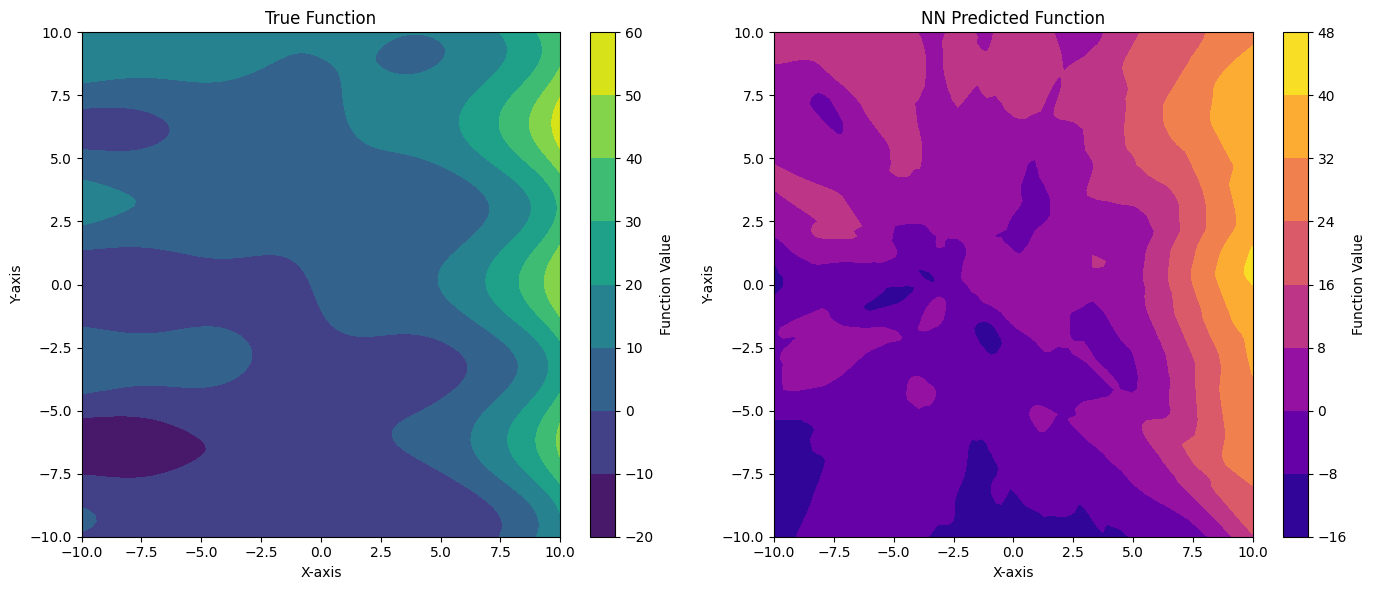

In [12]:
import matplotlib.pyplot as plt

# Reshape predictions to grid format for visualization
Z_pred = model.predict(inputs_final) * outputs_std + outputs_mean
Z_pred = Z_pred.reshape(X.shape)

# Plot comparison of the true function and the model predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the true function
axes[0].contourf(X,Y,Z, cmap='viridis')
axes[0].set_title("True Function")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Y-axis")
axes[0].colorbar = plt.colorbar(axes[0].contourf(X,Y,Z, cmap='viridis'), ax=axes[0], label="Function Value")

# Plot the predicted function
axes[1].contourf(X, Y, Z_pred, cmap='plasma')
axes[1].set_title("NN Predicted Function")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Y-axis")
axes[1].colorbar = plt.colorbar(axes[1].contourf(X, Y, Z_pred, cmap='plasma'), ax=axes[1], label="Function Value")

plt.tight_layout()
plt.show()